We are trying to explain the reason why there is difference in space and time with the baseline. Is it chance ? Or is it specific to space 
or time ?

In [68]:
import random
random.seed(42)

import sys

sys.path.append('../')
sys.path.append('../networks/')

import sqlite3
import pandas as pd
pd.options.mode.chained_assignment = None

import os
import polars as pl

import random
random.seed(42)

import sys

sys.path.append('../')
sys.path.append('../src')
from functions.feat_network import get_edge_node_table, filter_edge_table
from functions.feat_visualization import sygma_graph_leiden
from functions.datamodel import OptimumParameter
from sklearn.metrics import adjusted_rand_score
from dotenv import load_dotenv
import scipy.stats as stats

#from region_filters import columns_eu_unique, columns_non_eu_unique
from optimal_clustering import optimal_clustering


In [69]:
# Load the environment variables from the .env file
dotenv_path = os.path.join('../', '.env')
load_dotenv(dotenv_path)

True

In [70]:

dict_op = optimal_clustering
dict_op = OptimumParameter(**dict_op)

from functions.env import DB_SCIENCE_PATH_NEW

In [71]:
conn = sqlite3.connect(DB_SCIENCE_PATH_NEW)
#conn_full_db = sqlite3.connect(os.getenv("FULL_DB_PATH"))

df_baseline = pd.read_sql("SELECT * FROM optimal_partition_100_europe", conn)
df_baseline = df_baseline.rename(columns = {'community':'community_baseline'})

df_baseline

,community_baseline,node
0,0,philosopher
1,0,theologian
2,0,historian
3,0,sociologist
4,0,anthropologist
5,0,political scientist
6,0,logician
7,0,linguist
8,0,economist
9,0,archeologist


In [72]:
#df_ind = pd.read_sql("SELECT * FROM individual_id_cleaned_occupations", conn)
#all_individuals = list(set(df_ind.wikidata_id))

We compute different clusetring for different sizes of samples of individuals

In [73]:
#df_ind_regions = pd.read_sql("SELECT * FROM temporal_data", conn)
#df_ind_regions = df_ind_regions[['wikidata_id', 'region_code']].drop_duplicates()

For every region, compute the distance to the baseline ARI

In [74]:
df_individuals = pd.read_sql("SELECT * FROM individuals_occupation_information", conn)
df_ind_regions = pd.read_sql("SELECT * FROM individuals_regions", conn)
df_ind_regions = df_ind_regions.drop('individual_name', axis=1)
df_final = pd.merge(df_individuals, df_ind_regions, on = 'individual_wikidata_id')

In [75]:
regions_non_europe = ['re_ottoman_turkey',
're_arabic_world',
're_persian_world',
're_indian_world',
're_chinese_world',
're_korea',
're_japan',
're_south_east_asia']

regions_europe = [
're_nordic_countries'
're_british_islands',
're_low_countries',
're_france',
're_spain',
're_italy',
're_german_world',
're_central_europe',
're_slav_world'
're_balkans']

regions_classique = ['re_greek_world', 're_latin']

regions_keep = regions_non_europe + regions_europe + regions_classique

df_ind_regions_clean = df_ind_regions[df_ind_regions['region_code'].isin(regions_keep)]
df_ind_regions_clean = df_ind_regions_clean.reset_index(drop=True)

df_occupations = pd.read_sql("SELECT * FROM cleaned_occupations_science", conn)
df_ind_regions_clean = df_ind_regions_clean.rename(columns = {'individual_wikidata_id':'wikidata_id'})

df_regions = pd.merge(df_ind_regions_clean, df_occupations, on = 'wikidata_id')


,wikidata_id,region_code,region_name
0,Q64556048,re_france,France
1,Q22691480,re_german_world,German world
2,Q28839152,re_france,France
3,Q80665311,re_low_countries,Low countries
4,Q38170611,re_german_world,German world
...,...,...,...
22803,Q5894051,re_korea,Korea
22804,Q12619924,re_korea,Korea
22805,Q6408542,re_korea,Korea
22806,Q11095247,re_korea,Korea


In [76]:
#columns_to_keep = columns_eu_unique + columns_non_eu_unique
#columns_to_keep = [region for region in columns_to_keep if region != 're_korea']

#columns_to_keep.remove('re_korea')
#columns_to_keep.remove('re_south_east_asia')


"""
df_regions = pd.merge(df_ind_regions, df_ind, on = 'wikidata_id')
df_regions = df_regions[df_regions['region_code'].isin(columns_to_keep)]
df_regions_name = pd.read_sql_query(
    "SELECT * FROM regions", conn_full_db
)

df_regions = pd.merge(df_regions, df_regions_name, on = 'region_code')
df_regions = df_regions.drop('region_code', axis=1)
df_regions = df_regions.rename(columns = {'region_name':'region_code'})
df_regions = df_regions.drop_duplicates()

"""

'\ndf_regions = pd.merge(df_ind_regions, df_ind, on = \'wikidata_id\')\ndf_regions = df_regions[df_regions[\'region_code\'].isin(columns_to_keep)]\ndf_regions_name = pd.read_sql_query(\n    "SELECT * FROM regions", conn_full_db\n)\n\ndf_regions = pd.merge(df_regions, df_regions_name, on = \'region_code\')\ndf_regions = df_regions.drop(\'region_code\', axis=1)\ndf_regions = df_regions.rename(columns = {\'region_name\':\'region_code\'})\ndf_regions = df_regions.drop_duplicates()\n\n'

In [77]:
min_individuals = 10

final_list = []
for region in list(set(df_regions['region_code'])):

    df_sample = df_regions[df_regions['region_code']==region]

    # count number of individuals with at least two occupations
    count_duplicate = df_sample[df_sample['region_code']==region]
    duplicate_counts = count_duplicate['wikidata_id'].value_counts()
    duplicate_counts = len(duplicate_counts[duplicate_counts > 1])

    print(region, duplicate_counts)

    if duplicate_counts <min_individuals:
        continue

    df_sample = df_sample[['wikidata_id', 'meta_occupation']].copy()
    len_individuals = len(set(df_sample['wikidata_id']))
    df_sample.columns = ["source", "target"]
    df_sample["weight"] = 1

    # Draw the graph
    df_sample = pl.from_pandas(df_sample)

    df_edge, df_nodes = get_edge_node_table(df_sample)

    df_edge_filter = df_edge[df_edge["weight"] >= 0]
    df_edge_filter = df_edge_filter[df_edge_filter["source"] != df_edge_filter["target"]]
    df_edge_filter = df_edge_filter[df_edge_filter["rank_count"] <= dict_op.n_neighbours]

    df_partition, g  = sygma_graph_leiden(
        df_edge_filter,
        df_nodes,
        edge_bins=10,
        node_bins=10,
        filepath="../cache/cache_graph.html",
    )    

    new_df = pd.merge(df_baseline, df_partition, on = 'node')
    ari = adjusted_rand_score(list(new_df['community']), list(new_df['community_baseline']))
    final_list.append({'sample_length':len_individuals, 'ari':ari, 'region':region})

final_df = pd.DataFrame(final_list)
final_df = final_df.sort_values('ari', ascending=False)

re_south_east_asia 11
re_greek_world 127
re_italy 802
re_spain 198
re_japan 20
re_persian_world 49
re_indian_world 42
re_low_countries 269
re_france 1256
re_arabic_world 137
re_ottoman_turkey 10
re_korea 1
re_latin 21
re_central_europe 568
re_german_world 1634
re_chinese_world 76


Display the distance, add a regresion line and add labels

## plot with labels

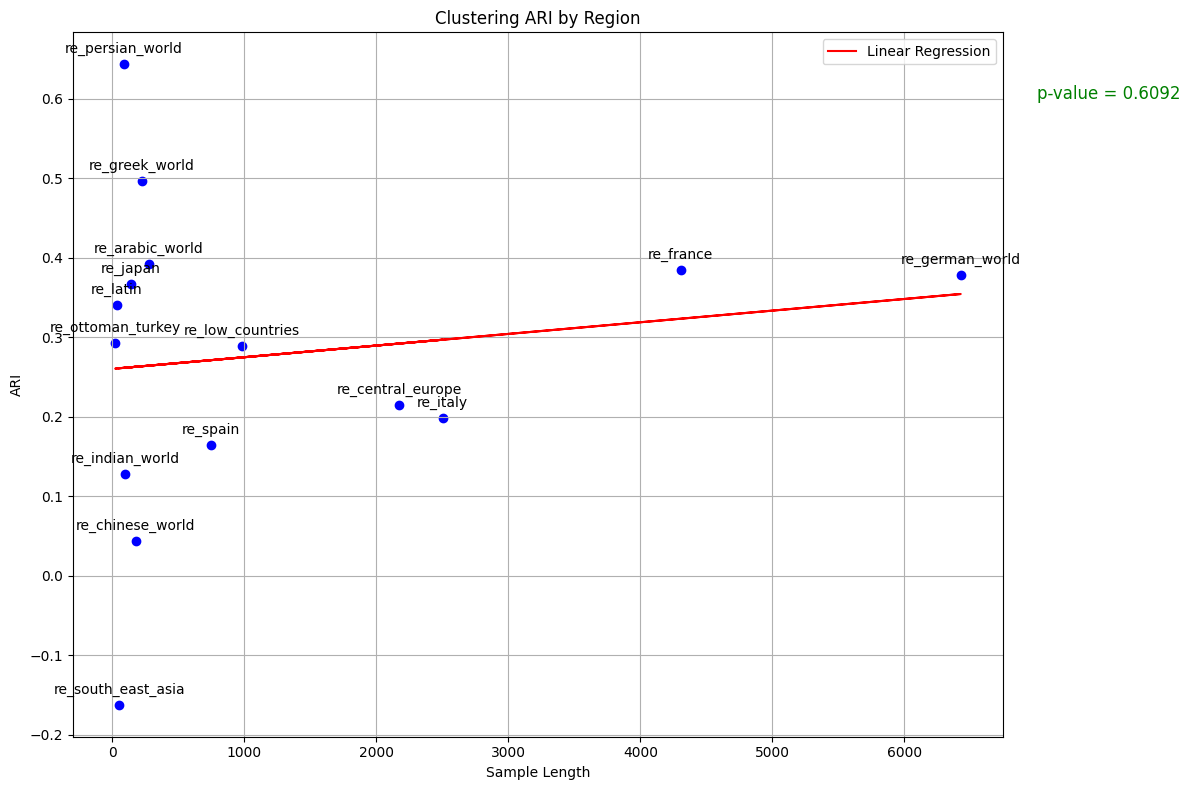

In [78]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

sample_lengths = [entry for entry in final_df['sample_length']]
ari_values = [entry for entry in final_df['ari']]
regions = [entry for entry in final_df['region']]

# Create a scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(sample_lengths, ari_values, color='blue')

# Add labels for each point
for i, region in enumerate(regions):
    plt.text(sample_lengths[i], ari_values[i]+0.01, region, fontsize=10, ha='center', va='bottom')

# Set plot labels and title
plt.xlabel('Sample Length')
plt.ylabel('ARI')
plt.title('Clustering ARI by Region')
plt.grid(True)

# Linear regression
X = final_df[['sample_length']]
y = final_df['ari']

X = sm.add_constant(X)  # Adding a constant term to the predictor
model = sm.OLS(y, X).fit()

# Get the p-value from the model summary
p_value = model.pvalues[1]

y_pred = model.predict(X)
plt.plot(X['sample_length'], y_pred, color='r', label='Linear Regression')

# Display p-value on the plot
plt.text(7000, 0.6, f'p-value = {p_value:.4f}', fontsize=12, color='green')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Compute the same analysis with fake sample of the size of the countries

In [79]:
list(set(df_regions.region_code))

['re_south_east_asia',
 're_greek_world',
 're_italy',
 're_spain',
 're_japan',
 're_persian_world',
 're_indian_world',
 're_low_countries',
 're_france',
 're_arabic_world',
 're_ottoman_turkey',
 're_korea',
 're_latin',
 're_central_europe',
 're_german_world',
 're_chinese_world']

In [85]:
"""
import random

list_individuals = list(set(df_regions.wikidata_id))

df_regions = pd.merge(df_ind_regions, df_ind, on = 'wikidata_id')
df_regions = df_regions[df_regions['region_code'].isin(columns_to_keep)]
df_regions_name = pd.read_sql_query(
    "SELECT * FROM regions", conn_full_db
)

df_regions = pd.merge(df_regions, df_regions_name, on = 'region_code')
df_regions = df_regions.drop('region_code', axis=1)
df_regions = df_regions.rename(columns = {'region_name':'region_code'})


"""
final_list = []
list_individuals = list(set(df_regions.wikidata_id))
for region in list(set(df_regions['region_code'])):
    
    try:
        df_region_filter = df_regions[df_regions['region_code']==region]
        len_ind_region = len(set(df_region_filter['wikidata_id']))
        
        
        # count number of individuals with at least two occupations
        count_duplicate = df_region_filter[df_region_filter['region_code']==region]
        duplicate_counts = count_duplicate['wikidata_id'].value_counts()
        duplicate_counts = len(duplicate_counts[duplicate_counts > 1])

        print(region, duplicate_counts)

        if duplicate_counts <min_individuals:
            continue
        

        random.seed(42)
        list_individuals_sample = random.sample(list_individuals, len_ind_region)
        df_sample = df_regions[df_regions['wikidata_id'].isin(list_individuals_sample)]
        df_sample = df_sample[['wikidata_id', 'meta_occupation']]
        len_individuals = len(set(df_sample['wikidata_id']))
        
        if len_individuals <= min_individuals:
            continue
            
        print(region, len_individuals)

        df_sample.columns = ["source", "target"]
        df_sample["weight"] = 1

        # Draw the graph
        df_sample = pl.from_pandas(df_sample)
        df_edge, df_nodes = get_edge_node_table(df_sample)
        df_edge_filter = df_edge[df_edge["weight"] >= 0]
        df_edge_filter = df_edge_filter[df_edge_filter["source"] != df_edge_filter["target"]]
        df_edge_filter = df_edge_filter[df_edge_filter["rank_count"] <= dict_op.n_neighbours]

        df_partition, g  = sygma_graph_leiden(
            df_edge_filter,
            df_nodes,
            edge_bins=10,
            node_bins=10,
            filepath="../cache/cache_graph.html",
        )

        new_df = pd.merge(df_baseline, df_partition, on = 'node')
        ari = adjusted_rand_score(list(new_df['community']), list(new_df['community_baseline']))
        final_list.append({'sample_length':len_individuals, 'ari':ari, 'region':region})
    except:
        pass

final_df_sample = pd.DataFrame(final_list)
final_df_sample['region'] = final_df_sample['region'] + '_sample'
final_df_sample = final_df_sample.rename(columns = {'ari':'ari_sample', 'region':'region_sample'})
df_plot = pd.merge(final_df, final_df_sample, on = 'sample_length')

re_south_east_asia 11
re_south_east_asia 53
re_greek_world 127
re_greek_world 225
re_italy 802
re_italy 2503
re_spain 198
re_spain 748
re_japan 20
re_japan 140
re_persian_world 49
re_persian_world 86
re_indian_world 42
re_indian_world 100
re_low_countries 269
re_low_countries 983
re_france 1256
re_france 4305
re_arabic_world 137
re_arabic_world 278
re_ottoman_turkey 10
re_ottoman_turkey 22
re_korea 1
re_latin 21
re_latin 33
re_central_europe 568
re_central_europe 2173
re_german_world 1634
re_german_world 6426
re_chinese_world 76
re_chinese_world 176


#### Plot Both

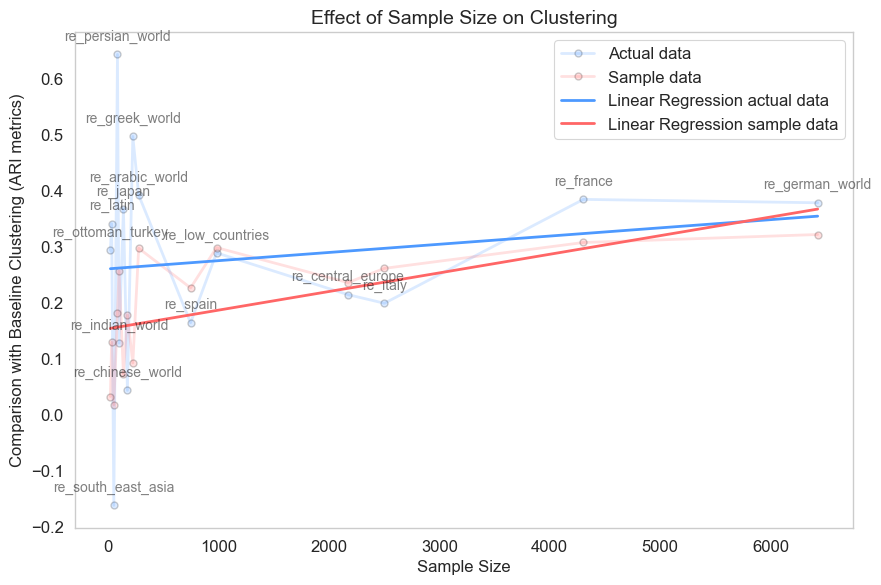

In [86]:
# Separate 'ari' and 'ari_sample' values into two lists
df_plot = df_plot.sort_values('sample_length')
ari_values = df_plot['ari']
ari_sample_values = df_plot['ari_sample']

# Perform a two-sample t-test
t_statistic, p_value = stats.ttest_rel(ari_values, ari_sample_values)

# Set the significance level
alpha = 0.05

# Extracting data from the DataFrame
sample_length = df_plot['sample_length']
ari = df_plot['ari']
ari_sample = df_plot['ari_sample']
region_sample = df_plot['region_sample']
region = df_plot['region']

import seaborn as sns  # Import seaborn for improved style

# Sort the DataFrame by 'sample_length'
df_plot = df_plot.sort_values(by='sample_length')

# Set the style using seaborn
sns.set(style="whitegrid", context="paper", font_scale=1.2)

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(9, 6))

# Define lighter colors
light_blue = (0.3, 0.6, 1.0)  # Light blue
light_red = (1.0, 0.4, 0.4)   # Light red

# Creating the line plot for 'ari' with a light blue color
#ax.plot(df_plot['sample_length'], df_plot['ari'], label='ari', color=light_blue, linestyle='-', linewidth=2)
ax.plot(df_plot['sample_length'], df_plot['ari'], label='ari', color=light_blue, linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_blue, alpha = 0.2)


# Creating the line plot for 'ari_sample' with a light red color
#ax.plot(df_plot['sample_length'], df_plot['ari_sample'], label='ari_sample', color=light_red,linestyle='-', linewidth=2)
ax.plot(df_plot['sample_length'], df_plot['ari_sample'], label='ari_sample', color=light_red, linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_red, alpha = 0.2)


# Adding labels and title
ax.set_xlabel('Sample Size', fontsize=12)
ax.set_ylabel('Comparison with Baseline Clustering (ARI metrics)', fontsize=12)
ax.set_title('Effect of Sample Size on Clustering', fontsize=14)

# Customize tick labels
ax.tick_params(axis='both', labelsize=12)
ax.grid(False)

# Add labels with region names on actual data points
for x, y_ari, y_ari_sample, region in zip(df_plot['sample_length'], df_plot['ari'], df_plot['ari_sample'], df_plot['region']):
    ax.annotate(region, (x, y_ari), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10, color='black', alpha = 0.5)
    #ax.annotate(region, (x, y_ari_sample), textcoords="offset points", xytext=(0, -20), ha='center', fontsize=10, color='red')
    
# Add linear regression
X = sm.add_constant(sample_length)  # Adding a constant term to the predictor
model = sm.OLS(ari, X).fit()
p_value = round(model.pvalues[1], 3)

model_2 = sm.OLS(ari_sample, X).fit()
p_value_2 = round(model_2.pvalues[1], 3)

plt.plot(df_plot['sample_length'], model.predict(X), color=light_blue, 
         label='Linear Regression', linewidth='2')

plt.plot(df_plot['sample_length'], model_2.predict(X), color=light_red, label='Linear Regression', linewidth='2')

ax.legend(fontsize=12, loc='best', labels=['Actual data', 
                                           'Sample data', 
                                           'Linear Regression actual data', 
                                            'Linear Regression sample data', 
                                           ])
                                           #f"Linear Regression Actual (p = {p_value}**)", 
                                           #f"Linear Regression Sample (p= {p_value_2}*)"])

# Adjust layout and save the plot as an image (optional)
plt.tight_layout()
#plt.savefig('line_plot.png', dpi=300)  # Save the plot as an image

# Show the plot
plt.show()

### Plot the logs

In [87]:
df_plot[['ari', 'ari_sample']].corr()

,ari,ari_sample
ari,1.000000,0.193557
ari_sample,0.193557,1.000000


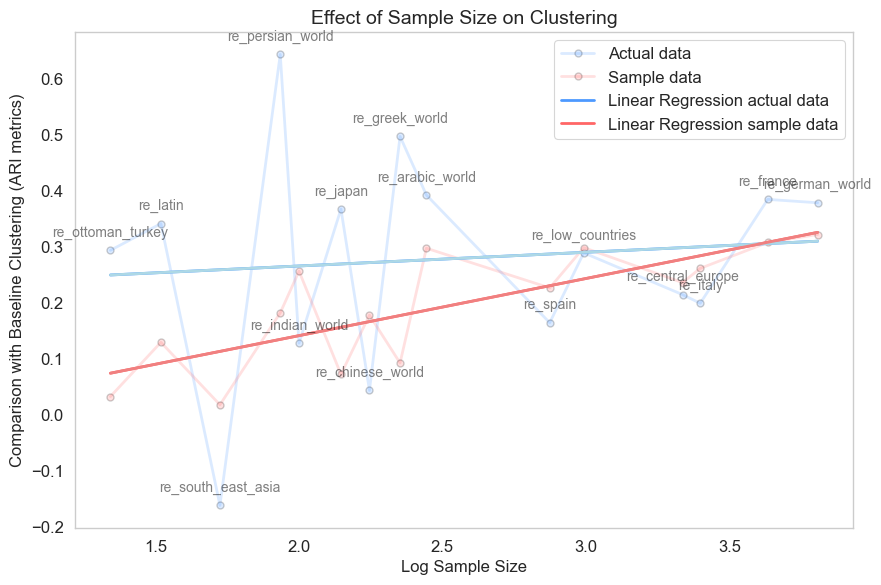

In [88]:
# Extracting data from the DataFrame
sample_length = np.log10(df_plot['sample_length'])
ari = df_plot['ari']
ari_sample = df_plot['ari_sample']
region_sample = df_plot['region_sample']
region = df_plot['region']
df_plot['log_size'] = np.log10(df_plot['sample_length'])

import seaborn as sns  # Import seaborn for improved style

# Sort the DataFrame by 'sample_length'
df_plot = df_plot.sort_values(by='log_size')

# Set the style using seaborn
sns.set(style="whitegrid", context="paper", font_scale=1.2)

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(9, 6))

# Define lighter colors
light_blue = (0.3, 0.6, 1.0)  # Light blue
light_red = (1.0, 0.4, 0.4)   # Light red

# Creating the line plot for 'ari' with a light blue color
#ax.plot(df_plot['sample_length'], df_plot['ari'], label='ari', color=light_blue, linestyle='-', linewidth=2)
ax.plot(df_plot['log_size'], df_plot['ari'], label='ari', color=light_blue, linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_blue, alpha = 0.2)

# Creating the line plot for 'ari_sample' with a light red color
#ax.plot(df_plot['sample_length'], df_plot['ari_sample'], label='ari_sample', color=light_red,linestyle='-', linewidth=2)
ax.plot(df_plot['log_size'], df_plot['ari_sample'], label='ari_sample', color=light_red, linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_red, alpha = 0.2)


# Adding labels and title
ax.set_xlabel('Log Sample Size', fontsize=12)
ax.set_ylabel('Comparison with Baseline Clustering (ARI metrics)', fontsize=12)
ax.set_title('Effect of Sample Size on Clustering', fontsize=14)

# Customize tick labels
ax.tick_params(axis='both', labelsize=12)
ax.grid(False)


# Add a legend

# Add labels with region names on actual data points
for x, y_ari, y_ari_sample, region in zip(df_plot['log_size'], df_plot['ari'], df_plot['ari_sample'], df_plot['region']):
    ax.annotate(region, (x, y_ari), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10, color='black', alpha = 0.5)
    #ax.annotate(region, (x, y_ari_sample), textcoords="offset points", xytext=(0, -20), ha='center', fontsize=10, color='red')

    
    
# Add linear regression
X = sm.add_constant(sample_length)  # Adding a constant term to the predictor
model = sm.OLS(ari, X).fit()
p_value = round(model.pvalues[1], 3)

# Get coefficients instead of p-values
coeff_1 = round(model.params[1], 3)
coeff_2 = round(model_2.params[1], 3)

model_2 = sm.OLS(ari_sample, X).fit()
p_value_2 = round(model_2.pvalues[1], 3)

plt.plot(df_plot['log_size'], model.predict(X), color=light_blue, 
         label='Linear Regression', linewidth='2')

plt.plot(df_plot['log_size'], model_2.predict(X), color=light_red, label='Linear Regression', linewidth='2')

plt.plot(df_plot['log_size'], model.predict(X), color='lightblue', label=f'Linear Regression (Coeff: {coeff_1})', linewidth=2)
plt.plot(df_plot['log_size'], model_2.predict(X), color='lightcoral', label=f'Linear Regression (Coeff: {coeff_2})', linewidth=2)


ax.legend(fontsize=12, loc='best', labels=['Actual data', 
                                           'Sample data', 
                                           'Linear Regression actual data', 
                                            'Linear Regression sample data', 
                                           ])
                                            #f'Linear Regression (Coeff: {coeff_1})',
                                            #f'Linear Regression (Coeff: {coeff_2})'])


    # Set new x-axis tick positions and labels
#new_xticks = list(df_plot['sample_length'])  # Use 'size' column for x-axis ticks
#print(new_xticks)
#plt.xticks(log_size, new_xticks)
# Adjust layout and save the plot as an image (optional)
plt.tight_layout()
#plt.savefig('line_plot.png', dpi=300)  # Save the plot as an image

# Show the plot
plt.show()


### Baseline Century

In [102]:
df_time = pd.read_sql("SELECT * FROM individuals_occupation_information", conn)
df_time = df_time[['individual_wikidata_id', 'birthyear']].drop_duplicates()
df_time = df_time.rename(columns = {'individual_wikidata_id':'wikidata_id'})

df_time = pd.merge(df_time, df_occupations, on = 'wikidata_id')
#df_time['century'] = df_time['birthyear'].apply(lambda x: round((x/100))*100)
df_time['time'] = df_time['birthyear'].apply(lambda year: round(year, -2))


In [103]:
final_list = []
#for time in [600]:
for time in sorted(list(set(df_time.time))):

    df_sample = df_time[df_time['time']==time]
    df_sample = df_sample[['wikidata_id', 'meta_occupation']]
    
     # count number of individuals with at least two occupations
    duplicate_counts = df_sample['wikidata_id'].value_counts()
    duplicate_counts = len(duplicate_counts[duplicate_counts > 1])

    print(time, duplicate_counts)

    if duplicate_counts <min_individuals:
        continue

    len_individuals = len(set(df_sample['wikidata_id']))
    df_sample.columns = ["source", "target"]
    df_sample["weight"] = 1

    # Draw the graph
    df_sample = pl.from_pandas(df_sample)
    df_edge, df_nodes = get_edge_node_table(df_sample)
    df_edge_filter = df_edge[df_edge["weight"] >= 0]
    df_edge_filter = df_edge_filter[df_edge_filter["source"] != df_edge_filter["target"]]
    df_edge_filter = df_edge_filter[df_edge_filter["rank_count"] <= dict_op.n_neighbours]

    df_partition, g =sygma_graph_leiden(
        df_edge_filter,
        df_nodes,
        edge_bins=10,
        node_bins=10,
        filepath=f"../cache/cache_graph_{time}.html",
    )    

    new_df = pd.merge(df_baseline, df_partition, on = 'node')
    ari = adjusted_rand_score(list(new_df['community']), list(new_df['community_baseline']))
    final_list.append({'sample_length':len_individuals, 'ari':ari, 'time':time})

final_df_time = pd.DataFrame(final_list)
final_df_time = final_df_time.sort_values('time')
final_df_time['log_size'] = np.log10(final_df_time['sample_length']+1)

0.0 8
nan 0
nan 0
nan 0
-2800.0 0
900.0 27
nan 0
nan 0
nan 0
1800.0 5279
nan 0
nan 0
nan 0
-600.0 10
-500.0 17
nan 0
nan 0
nan 0
-100.0 14
400.0 13
nan 0
nan 0
1300.0 39
nan 0
nan 0
nan 0
nan 0
nan 0
800.0 33
nan 0
nan 0
nan 0
1700.0 1319
nan 0
nan 0
nan 0
-2500.0 0
-2000.0 0
-1600.0 0
-1100.0 0
-700.0 0
-200.0 17
200.0 8
300.0 2
700.0 11
1100.0 38
1200.0 46
1600.0 612
nan 0
nan 0
nan 0
nan 0
nan 0
nan 0
nan 0
nan 0
nan 0
nan 0
nan 0
nan 0
-1300.0 0
-1200.0 0
nan 0
-800.0 1
-400.0 31
-300.0 10
100.0 9
500.0 10
600.0 8
1000.0 36
1400.0 86
1500.0 307


## Plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


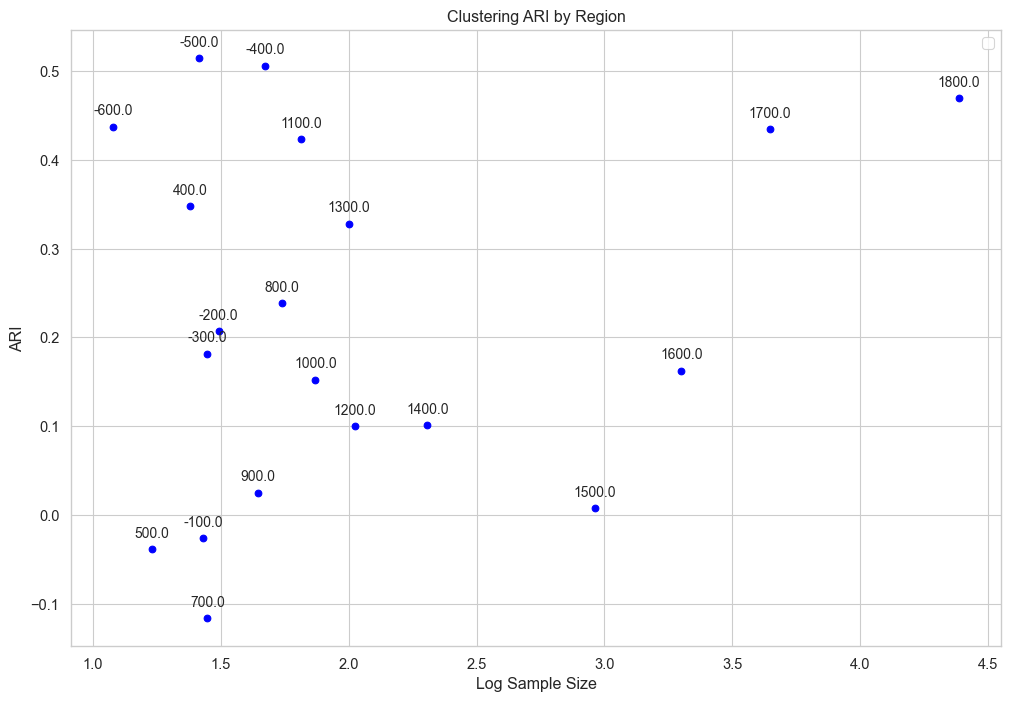

<Figure size 640x480 with 0 Axes>

In [104]:
sample_lengths = [entry for entry in final_df_time['log_size']]
ari_values = [entry for entry in final_df_time['ari']]
times = [entry for entry in final_df_time['time']]

# Create a scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(sample_lengths, ari_values, color='blue')

# Add labels for each point
for i, time in enumerate(times):
    plt.text(sample_lengths[i], ari_values[i]+0.01, time, fontsize=10, ha='center', va='bottom')

# Set plot labels and title
plt.xlabel('Log Sample Size')
plt.ylabel('ARI')
plt.title('Clustering ARI by Region')
plt.grid(True)


plt.legend()
plt.grid(True)
plt.show()

# Show the plot
plt.tight_layout()
plt.show()

In [105]:
import random

list_individuals = list(set(df_time.wikidata_id))

final_list = []
for time in list(set(df_time['time'])):
    
    try:
    
        df_time_filter = df_time[df_time['time']==time]
        len_ind_time = len(set(df_time_filter['wikidata_id']))
        
        
         # count number of individuals with at least two occupations
        duplicate_counts = df_time_filter['wikidata_id'].value_counts()
        duplicate_counts = len(duplicate_counts[duplicate_counts > 1])

        print(time, duplicate_counts)

        if duplicate_counts <min_individuals:
            continue

        
        random.seed(42)
        list_individuals_sample = random.sample(list_individuals, len_ind_time)
        df_sample = df_time[df_time['wikidata_id'].isin(list_individuals_sample)]
        df_sample = df_sample[['wikidata_id', 'meta_occupation']]
        
    
        len_individuals = len(set(df_sample['wikidata_id']))        
   
        df_sample.columns = ["source", "target"]
        df_sample["weight"] = 1

        # Draw the graph
        df_sample = pl.from_pandas(df_sample)

        df_edge, df_nodes = get_edge_node_table(df_sample)

        df_edge_filter = filter_edge_table(
            df_edge,
            edge_rule=dict_op.edge_rule,
            top_directed_neighbours=dict_op.n_neighbours,
            normalize_on_top=False,
            min_count_link=0,
        )

        df_partition, g = sygma_graph_leiden(
            df_edge_filter,
            df_nodes,
            edge_bins=10,
            node_bins=10,
            filepath="../cache/cache_graph.html",
        )    

        from sklearn.metrics import adjusted_rand_score

        new_df = pd.merge(df_baseline, df_partition, on = 'node', how ='outer')
        #new_df = pd.merge(df_baseline, df_partition, on = 'node')
        new_df = new_df.fillna(4)
        ari = adjusted_rand_score(list(new_df['community']), list(new_df['community_baseline']))

        final_list.append({'sample_length':len_individuals, 'ari':ari, 'time':time})
    except:
        pass
    
final_df_time_sample = pd.DataFrame(final_list)
final_df_time_sample = final_df_time_sample.sort_values('time')
final_df_time_sample = final_df_time_sample.rename(columns = {'ari':'ari_sample', 'time':'time_sample'})
df_plot_sample = pd.merge(final_df_time_sample, final_df_time, on = ['sample_length'])

df_plot_sample['log_size'] = np.log10(df_plot_sample['sample_length']+1)
df_plot_sample = df_plot_sample[df_plot_sample['sample_length']>10]

0.0 8
nan 0
nan 0
nan 0
900.0 27
nan 0
nan 0
nan 0
1800.0 5279
nan 0
nan 0
nan 0
-500.0 17
nan 0
nan 0
nan 0
400.0 13
-2800.0 0
nan 0
nan 0
1300.0 39
nan 0
nan 0
-100.0 14
nan 0
nan 0
nan 0
800.0 33
nan 0
nan 0
nan 0
1700.0 1319
nan 0
nan 0
nan 0
-600.0 10
300.0 2
1200.0 46
-2000.0 0
-1100.0 0
-200.0 17
700.0 11
-2500.0 0
-700.0 0
1600.0 612
-1600.0 0
nan 0
nan 0
nan 0
nan 0
nan 0
nan 0
200.0 8
nan 0
nan 0
nan 0
1100.0 38
nan 0
nan 0
nan 0
-1200.0 0
nan 0
-300.0 10
600.0 8
1500.0 307
-800.0 1
100.0 9
1000.0 36
-1300.0 0
-400.0 31
500.0 10
1400.0 86


Plot the T statistics

In [106]:

ari_values = df_plot_sample['ari']
ari_sample_values = df_plot_sample['ari_sample']

# Perform a two-sample t-test
t_statistic, p_value = stats.ttest_rel(ari_values, ari_sample_values)

# Set the significance level
alpha = 0.05
t_statistic

2.0112968682614483

In [107]:
df_plot_sample[['ari_sample', 'ari']].corr()

,ari_sample,ari
ari_sample,1.000000,0.210874
ari,0.210874,1.000000


0.14419
0.0


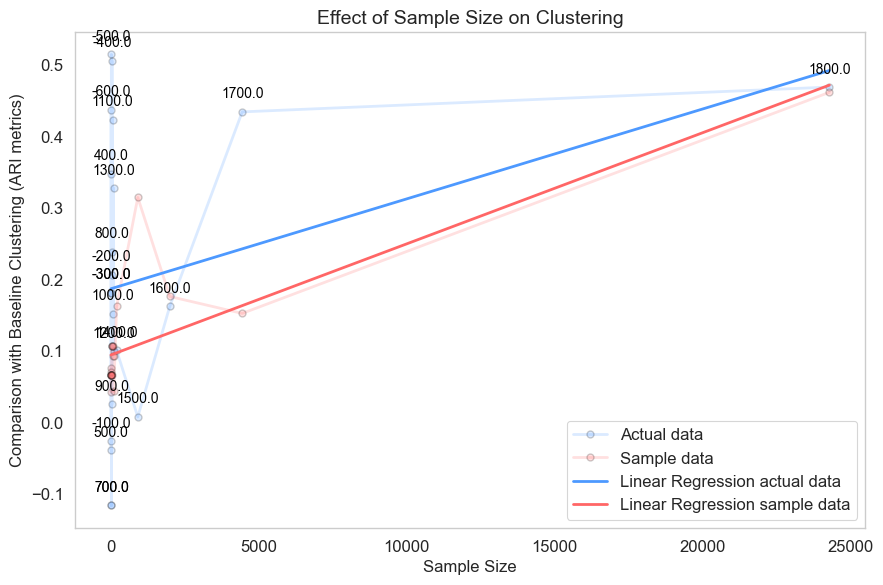

In [108]:
# Extracting data from the DataFrame
sample_length = df_plot_sample['sample_length']
ari = df_plot_sample['ari']
ari_sample = df_plot_sample['ari_sample']
times_sample = df_plot_sample['time_sample']
times = df_plot_sample['time']

# Sort the DataFrame by 'sample_length'
df_plot_sample = df_plot_sample.sort_values(by='sample_length')

# Set the style using seaborn
sns.set(style="whitegrid", context="paper", font_scale=1.2)

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(9, 6))

# Define lighter colors
light_blue = (0.3, 0.6, 1.0)  # Light blue
light_red = (1.0, 0.4, 0.4)   # Light red

# Creating the line plot for 'ari' with a light blue color
ax.plot(df_plot_sample['sample_length'], df_plot_sample['ari'], label='ari', color=light_blue, linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_blue, alpha = 0.2)

# Creating the line plot for 'ari_sample' with a light red color
ax.plot(df_plot_sample['sample_length'], df_plot_sample['ari_sample'], label='ari_sample', color=light_red,linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_red, alpha = 0.2)

# Adding labels and title
ax.set_xlabel('Sample Size', fontsize=12)
ax.set_ylabel('Comparison with Baseline Clustering (ARI metrics)', fontsize=12)
ax.set_title('Effect of Sample Size on Clustering', fontsize=14)

# Customize tick labels
ax.tick_params(axis='both', labelsize=12)
ax.grid(False)



# Add a legend
ax.legend(fontsize=12, loc='best', labels=['Actual data', 'Sample data'])

# Add labels with region names on actual data points
for x, y_ari, time in zip(df_plot_sample['sample_length'], df_plot_sample['ari'], df_plot_sample['time']):
    ax.annotate(time, (x, y_ari), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10, color='black')
    #ax.annotate(region, (x, y_ari_sample), textcoords="offset points", xytext=(0, -20), ha='center', fontsize=10, color='red')
    
    
# Add linear regression
X = sm.add_constant(list(df_plot_sample['sample_length']))  # Adding a constant term to the predictor
model = sm.OLS(ari, X).fit()
p_value = round(model.pvalues[1], 5)

model_2 = sm.OLS(ari_sample, X).fit()
p_value_2 = round(model_2.pvalues[1], 5)
print(p_value)
print(p_value_2)


plt.plot(df_plot_sample['sample_length'], model.predict(X), color=light_blue, 
         label='Linear Regression', linewidth='2')

plt.plot(df_plot_sample['sample_length'], model_2.predict(X), color=light_red, 
         label='Linear Regression', linewidth='2')



ax.legend(fontsize=12, loc='best', labels=['Actual data', 
                                           'Sample data', 
                                           'Linear Regression actual data', 
                                            'Linear Regression sample data', 
                                           ])
                                           #f"Linear Regression Actual (p = {p_value}**)", 
                                           #f"Linear Regression Sample (p= {p_value_2}**)"])



    # Set new x-axis tick positions and labels
#new_xticks = list(df_plot_sample['sample_length'])  # Use 'size' column for x-axis ticks
#print(new_xticks)
#plt.xticks(log_size, new_xticks)


plt.tight_layout()
#plt.savefig('line_plot.png', dpi=300)  # Save the plot as an image

# Show the plot
plt.show()

In [ ]:
from sklearn.linear_model import RANSACRegressor

2    -0.029412
4     0.181818
3    -0.120000
0     0.927835
6     0.175412
1     0.042553
5    -0.076768
7     0.112150
8     0.217593
10    0.238667
9     0.089971
11    0.150000
12    0.307852
13    0.198960
14    0.487836
15    0.171759
Name: ari, dtype: float64

0.28796
0.0


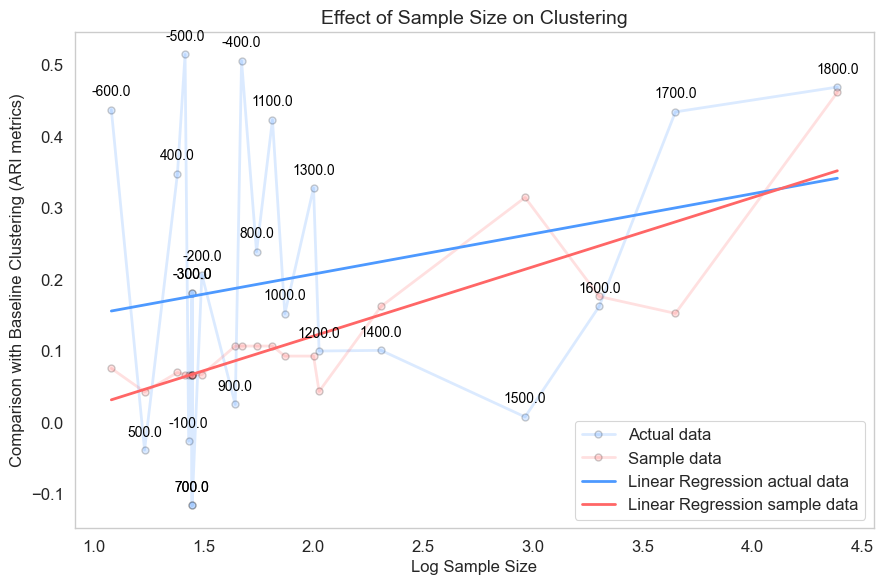

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for improved style

# Extracting data from the DataFrame
log_size = df_plot_sample['log_size']
ari = df_plot_sample['ari']
ari_sample = df_plot_sample['ari_sample']
times_sample = df_plot_sample['time_sample']
times = df_plot_sample['time']

# Sort the DataFrame by 'sample_length'
df_plot_sample = df_plot_sample.sort_values(by='log_size')

# Set the style using seaborn
sns.set(style="whitegrid", context="paper", font_scale=1.2)

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(9, 6))

# Define lighter colors
light_blue = (0.3, 0.6, 1.0)  # Light blue
light_red = (1.0, 0.4, 0.4)   # Light red

# Creating the line plot for 'ari' with a light blue color
ax.plot(df_plot_sample['log_size'], df_plot_sample['ari'], label='ari', color=light_blue, linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_blue, alpha = 0.2)

# Creating the line plot for 'ari_sample' with a light red color
ax.plot(df_plot_sample['log_size'], df_plot_sample['ari_sample'], label='ari_sample', color=light_red,linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_red, alpha = 0.2)

# Adding labels and title
ax.set_xlabel('Log Sample Size', fontsize=12)
ax.set_ylabel('Comparison with Baseline Clustering (ARI metrics)', fontsize=12)
ax.set_title('Effect of Sample Size on Clustering', fontsize=14)

# Customize tick labels
ax.tick_params(axis='both', labelsize=12)
ax.grid(False)


# Add a legend
ax.legend(fontsize=12, loc='best', labels=['Actual data', 'Sample data'])

# Add labels with region names on actual data points
for x, y_ari, time in zip(df_plot_sample['log_size'], df_plot_sample['ari'], df_plot_sample['time']):
    ax.annotate(time, (x, y_ari), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10, color='black')
    #ax.annotate(region, (x, y_ari_sample), textcoords="offset points", xytext=(0, -20), ha='center', fontsize=10, color='red')
    
    
# Add linear regression
X = sm.add_constant(list(df_plot_sample['log_size']))  # Adding a constant term to the predictor
model = sm.OLS(ari, X).fit()
p_value = round(model.pvalues[1], 5)


model_2 = sm.OLS(ari_sample, X).fit()
p_value_2 = round(model_2.pvalues[1], 5)
print(p_value)
print(p_value_2)

"""
# Fit RANSAC regression model to 'ari'
ransac_ari = RANSACRegressor()
ransac_ari.fit(np.array(df_plot_sample['log_size']).reshape(-1, 1), df_plot_sample['ari'])
ari_ransac_line = ransac_ari.predict(np.array(df_plot_sample['log_size']).reshape(-1, 1))
ax.plot(df_plot_sample['log_size'], ari_ransac_line, color='green', label='RANSAC Regression (ari)', linewidth=2)

# Fit RANSAC regression model to 'ari_sample'
ransac_ari_sample = RANSACRegressor()
ransac_ari_sample.fit(np.array(df_plot_sample['log_size']).reshape(-1, 1), df_plot_sample['ari_sample'])
ari_sample_ransac_line = ransac_ari_sample.predict(np.array(df_plot_sample['log_size']).reshape(-1, 1))
ax.plot(df_plot_sample['log_size'], ari_sample_ransac_line, color='orange', label='RANSAC Regression (ari_sample)', linewidth=2)

"""



plt.plot(df_plot_sample['log_size'], model.predict(X), color=light_blue, 
         label='Linear Regression', linewidth='2')

plt.plot(df_plot_sample['log_size'], model_2.predict(X), color=light_red, 
         label='Linear Regression', linewidth='2')



ax.legend(fontsize=12, loc='best', labels=['Actual data', 
                                           'Sample data', 
                                           'Linear Regression actual data', 
                                            'Linear Regression sample data', 
                                           ]) 
                                           #f"Linear Regression Actual (p = {p_value}**)", 
                                           #f"Linear Regression Sample (p= {p_value_2}**)"])

# Set new x-axis tick positions and labels
#new_xticks = list(df_plot_sample['sample_length'])  # Use 'size' column for x-axis ticks
#print(new_xticks)
#plt.xticks(log_size, new_xticks)


plt.tight_layout()
#plt.savefig('line_plot.png', dpi=300)  # Save the plot as an image

# Show the plot
plt.show()